In [1]:
from IPython.display import clear_output

In [2]:
#@markdown # Install requirements

%cd /content
!git clone https://github.com/sd-fabric/fabric.git
%cd /content/fabric
!pip install -r requirements.txt
!pip install -e .

try:
  from fabric.generator import AttentionBasedGenerator
  from fabric.iterative import IterativeFeedbackGenerator
except:
  raise
else:
  clear_output()

In [3]:
!pip install googletrans==4.0.0-rc1
clear_output()

In [4]:
!pip install sentence_transformers
clear_output()

In [5]:
!pip install transformers==4.27.4
clear_output()

In [6]:
import googletrans
import torch
from googletrans import Translator
from sentence_transformers import SentenceTransformer, util
from PIL import Image

In [ ]:
#@markdown # Preparing the model
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython.utils import capture
from IPython.display import clear_output
from PIL import Image

from fabric.generator import AttentionBasedGenerator
from fabric.iterative import IterativeFeedbackGenerator


#@markdown Please provide either:
#@markdown 1. a model name referencing a Huggingface Diffusers checkpoint or
#@markdown 2. a URL to a StableDiffusion v1.5 checkpoint.

model_name = "dreamlike-art/dreamlike-photoreal-2.0" #@param {type:"string"}
model_ckpt = "" #@param {type:"string"}

model_name = model_name if model_name else None
model_ckpt = model_ckpt if model_ckpt else None

base_generator = AttentionBasedGenerator(
  model_name=model_name,
  model_ckpt=model_ckpt,
  torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
)

if torch.cuda.is_available():
  base_generator.to("cuda")

generator = IterativeFeedbackGenerator(base_generator)

clear_output()

In [9]:
language_keys = list(googletrans.LANGUAGES.keys())
language_values = list(googletrans.LANGUAGES.values())
Dropdown_ = widgets.Dropdown(
    options=language_values,
    description='choose your language',
)
output = widgets.Output()

def on_change(change):
  clear_output()
  source_language = language_keys[language_values.index(change['new'])]
  f = open('/content/source_language.txt', 'w')
  f.write(source_language)
  f.close()
  display(Dropdown_)
  print(f"The language is {change['new']}")

Dropdown_.observe(on_change, names='value')
display(Dropdown_)

Dropdown(description='choose your language', index=21, options=('afrikaans', 'albanian', 'amharic', 'arabic', …

The language is english


In [10]:
def translate_text(input_text, source_language):
    translator = Translator()

    # Translate the input text to the target language
    translated_text = translator.translate(input_text, 'en', source_language)

    return translated_text.text

In [11]:
def get_image_rating(images, prompt):
  #Load CLIP model
  model = SentenceTransformer('clip-ViT-B-32')

  #Encode an image:
  img_emb = model.encode(images)

  #Encode text descriptions
  text_emb = model.encode(prompt)

  #Compute cosine similarities
  cos_scores = util.cos_sim(img_emb, text_emb)
  return cos_scores

In [12]:
Your_prompt = 'A bustling city street at night.'
f = open('/content/prompt.txt', 'w')
f.write(Your_prompt)
f.close()

tensor([[0.3030],
        [0.2895],
        [0.2957],
        [0.2838]])
avg rate:  tensor(0.2930)


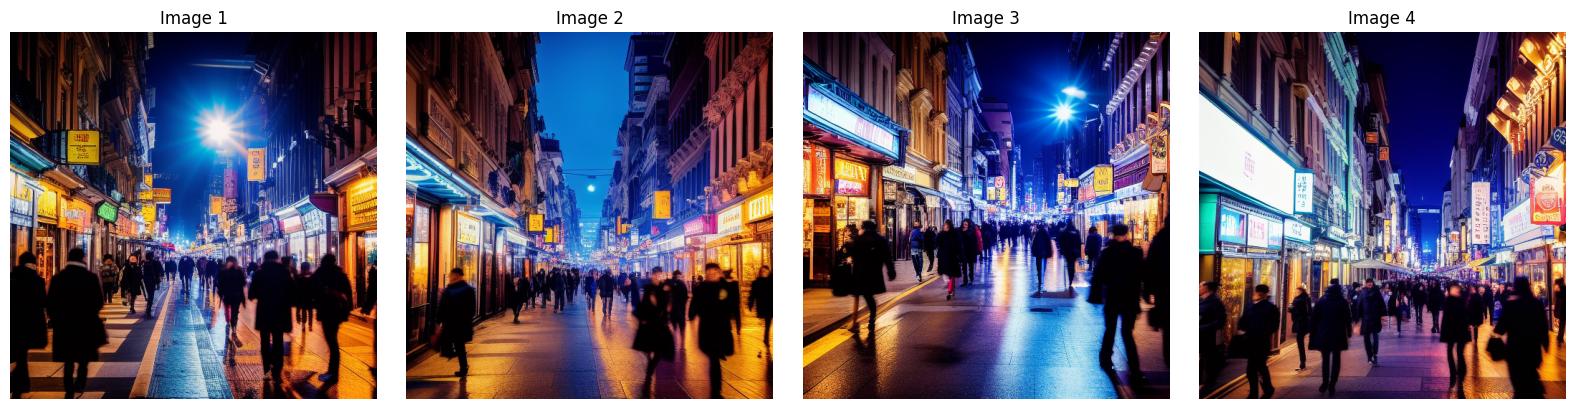

In [14]:
#@markdown # Running FABRIC

# prompt = "a painting of sea" #@param {type: "string"}
negative_prompt = "lowres, bad anatomy, bad hands, cropped, worst quality" #@param {type: "string"}
denoising_steps = 20 #@param {type: "number"}
guidance_scale = 6.0 #@param {type: "number"}
feedback_start = 0.0 #@param {type: "number"}
feedback_end = 0.5 #@param {type: "number"}

#@markdown Explanation of the parameters:
#@markdown - `denoising_steps`: Number of steps in the denoising schedule
#@markdown - `guidance_scale`: Strength of the classifier-free guidance (same as for any diffusion model)
#@markdown - `feedback_start`: From which point in the diffusion process feedback should be added (0.0 -> from the beginning, 0.5 -> from the halfway point)
#@markdown - `feedback_end`: Until which point feedback should be added (0.5 -> until the halfway point, 1.0 -> until the end)
#@markdown
#@markdown **NOTE**: GPU memory scales with the number of feedback images, so a large number of feedback images will require large amounts of memory.


def display_images(images, n_cols=4, size=4):
    n_rows = int(np.ceil(len(images) / n_cols))
    fig = plt.figure(figsize=(size * n_cols, size * n_rows))
    for i, img in enumerate(images):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        ax.imshow(img)
        ax.set_title(f"Image {i+1}")
        ax.axis("off")
    fig.tight_layout()
    return fig


def get_selected_idx(prompt, min_idx=0, max_idx=3):
  range_str = ", ".join(map(str, range(min_idx + 1, max_idx + 2)))
  selected_idx = input(f"{prompt} ({range_str}) ")

  if not selected_idx:
    return None

  try:
    selected_idx = int(selected_idx)
  except:
    print(f"Unable to parse '{selected_idx}', selecting no feedback.")
    return None
  else:
    if selected_idx < min_idx + 1 or selected_idx > max_idx + 1:
      print("Index out of bounds, selecting no feedback.")
      return None
    else:
      return selected_idx - 1


def get_feedback(images) -> tuple[list[Image.Image], list[Image.Image]]:
    display_images(images)
    plt.show()
    #liked_idx = get_selected_idx("Which image do you like most?")
    #disliked_idx = get_selected_idx("Which image do you like least?")

import ipywidgets as widgets
import functools
from IPython.display import display

images = []

def clicked_like(img, i, _):
  generator.give_feedback(liked=[img])
  text = widgets.Label(value=f"Added image {i+1} to liked images")
  display(text)

def clicked_dislike(img, i, _):
  generator.give_feedback(disliked=[img])
  text = widgets.Label(value=f"Added image {i+1} to disliked images")
  display(text)

like_buttons = []
dislike_buttons = []
for i in range(4):
  like_button = widgets.Button(description=f"👍 Image {i+1}", button_style="success", tooltip="Add to liked images")
  like_buttons.append(like_button)

  dislike_button = widgets.Button(description=f"👎 Image {i+1}", button_style="danger", tooltip="Add to disliked images")
  dislike_buttons.append(dislike_button)

like_container = widgets.HBox(like_buttons)
dislike_container = widgets.HBox(dislike_buttons)

def next_round(_):
  clear_output()
  f = open("/content/prompt.txt", "r")
  prompt = f.readline()
  f.close()
  f = open("/content/source_language.txt", "r")
  source_language = f.readline()
  f.close()
  prompt = translate_text(prompt, source_language)
  images = generator.generate(
      prompt=prompt,
      negative_prompt=negative_prompt,
      denoising_steps=denoising_steps,
      guidance_scale=guidance_scale,
      feedback_start=feedback_start,
      feedback_end=feedback_end,
  )
  clear_output()
  rate = get_image_rating(images, prompt)
  print(rate)
  print('avg rate: ', torch.mean(rate))
  display_images(images)
  plt.show()

  for i in range(4):
    like_buttons[i]._click_handlers.callbacks = []
    dislike_buttons[i]._click_handlers.callbacks = []
    like_buttons[i].on_click(functools.partial(clicked_like, images[i], i))
    dislike_buttons[i].on_click(functools.partial(clicked_dislike, images[i], i))

  display(like_container)
  display(dislike_container)
  display(control_buttons)

def reset(_):
  generator.reset()
  text = widgets.Label(value="All feedback images have been cleared.")
  display(text)

next_round_button = widgets.Button(description="Next Round", button_style="info")
next_round_button.on_click(next_round)
reset_button = widgets.Button(description="Reset Feedback", tooltip="Clear all feedback images")
reset_button.on_click(reset)
control_buttons = widgets.HBox([next_round_button, reset_button])

generator.reset()
next_round(None)